In [3]:
import glob
import logging
import os
import numpy as np
import re
import soundfile


In [2]:
import scipy.signal
from scipy.signal import spectrogram

In [180]:
import keras.backend as K

from keras.layers import (BatchNormalization, Conv1D, Dense,
                          Input, GRU, TimeDistributed)
from keras.models import Model

In [182]:
K.backend()

SyntaxError: invalid syntax (<ipython-input-182-d4be51dbfa89>, line 1)

'tensorflow'

In [87]:
# step (int): Step size in milliseconds between windows
# window (int): FFT window size in milliseconds
# max_freq (int): Only FFT bins corresponding to frequencies between [0, max_freq] are returned

def spectrogram_from_file(filename, fft_length, hop_length):
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        print('sample_rate', sample_rate)
        window=np.hanning(fft_length)
        max_freq=sample_rate / 2
        eps=1e-14
        time_steps, freqs, sxx = scipy.signal.spectrogram(audio, fs=sample_rate, nperseg=fft_length, window=window, noverlap=hop_length)
        #ind = np.where(freqs <= max_freq)[0][-1] + 1 
        
        z=np.transpose(np.log(sxx[:, :] + eps))
        # plt.pcolormesh( freqs,time_steps, np.transpose(z))
        # plt.ylabel('Frequency [Hz]')
        # plt.xlabel('Time [sec]')
        # plt.show()
        return z 
        


In [120]:
spec = spectrogram_from_file('./wav/652-130726-0025.wav', 320, 160)


sample_rate 16000


In [109]:
spec.shape


(601, 161)

In [ ]:
plt.pcolormesh(bins,freqs, np.transpose(z))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time [sec]')
plt.show()

/Users/amolumbarkar/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


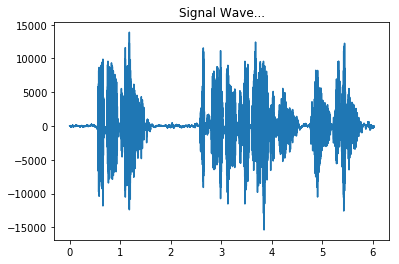

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open('./wav/652-129742-0000.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
fs = spf.getframerate()
Time=np.linspace(0, len(signal)/fs, num=len(signal))


plt.figure(1)
plt.title('Signal Wave...')
plt.plot(Time, signal)
plt.show()

In [62]:
def load_data(file_name):
    fileIds_ = []
    durations_ = []
    labels_ = []

    for line in open(file_name):
        split = line.strip().split()
        fileId = split[0]
        fileIds_.append(fileId)
        label = ''.join(split[1:]).lower()
        labels_.append(label)
        audio_file = './wav/' + os.path.join(fileId) + '.wav'
        audio = wave.open(audio_file)
        duration = float(audio.getnframes()) /audio.getframerate()
        audio.close()
        durations_.append(duration)
    return fileIds_, labels_, durations_
    

In [63]:
t_fileIds, t_labels, t_durations = load_data('train_data.txt')
train_sortedIds = [t_durations.index(x) for x in sorted(t_durations)]
train_durations = [x for x in sorted(t_durations)] 
train_labels = [t_labels[i] for i in train_sortedIds]
train_fileIds = [t_fileIds[i] for i in train_sortedIds]


In [71]:
len(train_labels), len(train_fileIds)

(57, 57)

In [72]:
val_fileIds, val_labels, val_durations = load_data('test_data.txt')

In [73]:
len(val_labels), len(val_fileIds)

(14, 14)

In [75]:
char_map_str = """
' 1| <SPACE> 2|a 3|b 4|c 5|d 6|e 7|f 8|g 9|h 10|i 11|j 12|k 13|l 14|m 15|n 16|o 17|p 18|q 19|r 20|s 21|t 22|u 23|v 24|w 25|x 26|y 27|z 28"""
char_map = {}
index_map = {}
for line in char_map_str.strip().split('|'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[2] = ' '

In [126]:
def text_to_int_sequence(text):
    """ Use a character map and convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [129]:
def prepare_batch(files, texts):
    features = [spectrogram_from_file(''.join('./wav/'+ a + '.wav') , 320, 160) for a in files]  # returns (timesteps, features
    input_lengths = [f.shape[0] for f in features]  
    feature_dim = features[0].shape[1]
    mb_size = len(features)
    timesteps = max(input_lengths)
    x = np.zeros((mb_size, timesteps, feature_dim))  # store timesteps and features for each batch 
    y = []
    label_lengths = []
    for i in range(mb_size):
        feature = features[i]
        # feature = normalize()
        x[i, :feature.shape[0], : ] = feature  # assigns value for each batch, all timesteps in second and all values in third dim
        label = text_to_int_sequence(texts[i])
        y.append(label)
        label_lengths.append(len(label))
    
    return {
        'x': x,
        'y': y,
        'texts': texts,
        'input_lengths':input_lengths,
        'label_lengths': label_lengths
    }
    

In [132]:
o = prepare_batch(train_fileIds[:2], train_labels[:2])


sample_rate 16000
sample_rate 16000


In [155]:
#build a GRU model

# input dim feature length 
input_dim = 161
recur_layers = 3
output_dim = 29

acoustic_input = Input(shape=(None, input_dim), name = 'acoustic_input')
conv_1d =  Conv1D(activation="relu", kernel_size=11, strides=2, name="conv_1d", padding="same", filters=1024)(acoustic_input) # try same
gru_1 = GRU(units=1024, activation='relu', name="rnn_1", return_sequences=True)(conv_1d)
gru_2 = GRU(units=1024, activation='relu', name="rnn_2", return_sequences=True)(gru_1)
gru_3 = GRU( units=1024, activation='relu', name="rnn_3", return_sequences=True)(gru_2)

# no softmax layer 
network_output = TimeDistributed(Dense(output_dim, name='dense',activation='linear'))(gru_3)

model = Model(input=acoustic_input, output=network_output)


/Users/amolumbarkar/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ac..., outputs=Tensor("ti...)`


TensorShape([Dimension(None), Dimension(None), Dimension(29)])

In [171]:
import sys 
sys.path.insert(0, 'ctc/python')
import ctc
import lasagne

In [175]:
acoustic_input = model.inputs[0]
network_output = model.outputs[0]
output_lengths = K.placeholder(ndim=1, dtype='int32')
label = K.placeholder(ndim=1, dtype='int32')
label_lengths = K.placeholder(ndim=1, dtype='int32') 
# swapping batch(0) and steps(1) required by CTC . Keeping output dim as is 29 
# Turn <minibatch_size, max_length, num_classes> into <max_length, minibatch_size, num_classes>

network_output = network_output.dimshuffle((1, 0, 2))

ctc_cost = ctc.cpu_ctc_th(network_output, output_lengths, label, label_lengths).mean()
trainable_vars = model.trainable_weights 
grads = K.gradients(ctc_cost, trainable_vars)
grads = lasagne.updates.total_norm_constraint(100)
updates = lasagne.updates.nesterov_momentum(grads, trainable_vars, learning_rate, 0.99)

AttributeError: 'Tensor' object has no attribute 'dimshuffle'

In [ ]:
# define model -> pass to function -> create model function 
# load data -> create batches - > use the model function to train
# repeat for validation 